In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_vqe import CutVQE
from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_qaoa import CutQAOA

ModuleNotFoundError: No module named 'qiskit.primitives.Estimator'

In [5]:
dir(qiskit.quantum_info.operators)

['CNOTDihedral',
 'Chi',
 'Choi',
 'Clifford',
 'Kraus',
 'Operator',
 'PTM',
 'Pauli',
 'PauliList',
 'ScalarOp',
 'SparsePauliOp',
 'Stinespring',
 'SuperOp',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'annotations',
 'anti_commutator',
 'average_gate_fidelity',
 'base_operator',
 'channel',
 'commutator',
 'custom_iterator',
 'diamond_norm',
 'dihedral',
 'double_commutator',
 'gate_error',
 'linear_op',
 'measures',
 'mixins',
 'op_shape',
 'operator',
 'pauli_basis',
 'predicates',
 'process_fidelity',
 'random',
 'scalar_op',
 'symplectic',
 'utils']

In [4]:
%pip install azure-quantum[qiskit]

zsh:1: no matches found: azure-quantum[qiskit]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

algorithm_globals.random_seed = 123
seed = 10598

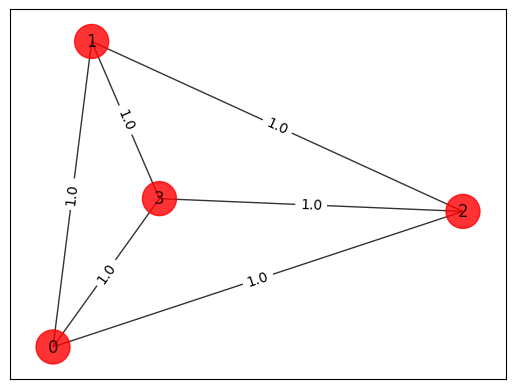

In [3]:
n = 4 # number of nodes in the graph
G = nx.random_regular_graph(3, n)

for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

pos = nx.spring_layout(G)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
#print(qp.prettyprint())
qubitOp, offset = qp.to_ising()
#print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [6]:
qubitOp.paulis

PauliList(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'])

In [99]:
from qiskit.algorithms import QAOA
from qiskit import Aer

optimizer = SPSA(maxiter=300)
backend = Aer.get_backend('aer_simulator')

# Change the number of reps if desired
qaoa = QAOA(optimizer=optimizer, reps=1, quantum_instance=backend)
qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)
qaoa.ansatz.decompose(reps=2).draw('mpl')

/tmp/ipykernel_3683/2743655176.py:8: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(optimizer=optimizer, reps=1, quantum_instance=backend)


AttributeError: 'SparsePauliOp' object has no attribute 'primitive_strings'

In [7]:
# print results
x = max_cut.sample_most_likely(qaoa_result.eigenstate)
print("energy:", qaoa_result.eigenvalue.real)
print("time:", qaoa_result.optimizer_time)
print("max-cut objective:", qaoa_result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

NameError: name 'qaoa_result' is not defined

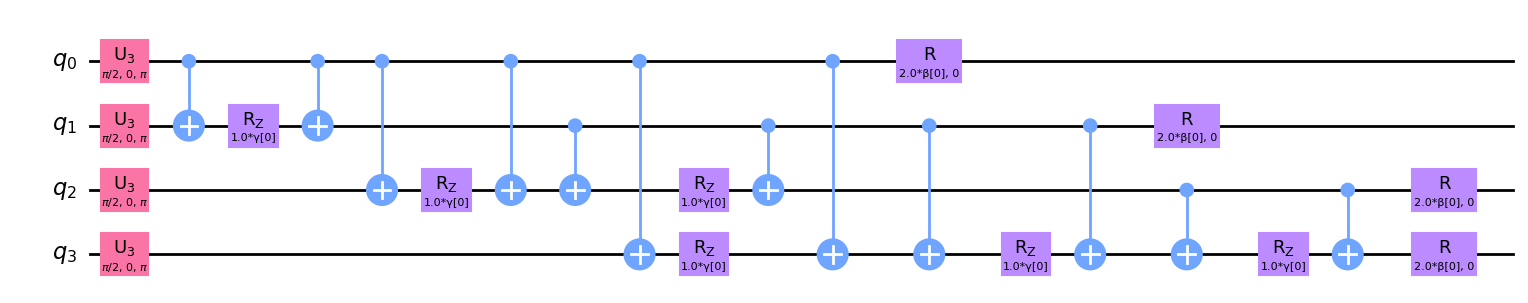

In [249]:
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

ansatz = QAOAAnsatz(qubitOp, reps=1, flatten=True)
ansatz.parameters
ansatz.decompose(reps=2).draw('mpl')

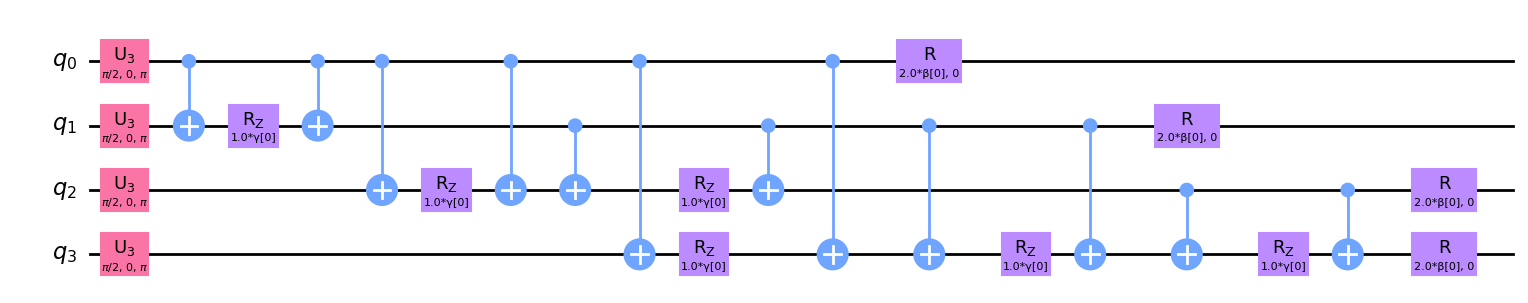

In [250]:
ansatz = ansatz.decompose(reps=2)

ansatz.draw('mpl')

In [237]:
theta = ParameterVector("θ", 10)
beta = ParameterVector("β", 10)
#type(theta[6]
str(theta[6])

#ansatz.data[-5].operation.params

'θ[6]'

In [251]:
from qiskit.circuit import Instruction
k = 0
for d in ansatz.data:
    if len(d.operation.params) > 0 and ('γ' in str(d.operation.params[0]) or 'β' in str(d.operation.params[0])): 
        print(d.operation.params)
        if 'β' in str(d.operation.params[0]):
            d.operation.params = [2*beta[k], 0]
        else:
            d.operation.params = [beta[k]]
        k+=1
        #print(d.operation.params)
ansatz.data

[ParameterExpression(1.0*γ[0])]
[ParameterExpression(1.0*γ[0])]
[ParameterExpression(1.0*γ[0])]
[ParameterExpression(1.0*γ[0])]
[ParameterExpression(2.0*β[0]), 0]
[ParameterExpression(1.0*γ[0])]
[ParameterExpression(2.0*β[0]), 0]
[ParameterExpression(1.0*γ[0])]
[ParameterExpression(2.0*β[0]), 0]
[ParameterExpression(2.0*β[0]), 0]


[CircuitInstruction(operation=Instruction(name='u3', num_qubits=1, num_clbits=0, params=[1.5707963267948966, 0, 3.141592653589793]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='u3', num_qubits=1, num_clbits=0, params=[1.5707963267948966, 0, 3.141592653589793]), qubits=(Qubit(QuantumRegister(4, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[ParameterVectorElement(β[0])]), qubits=(Qubit(QuantumRegister(4, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='u3', num_qubits=1, num_clbits=0

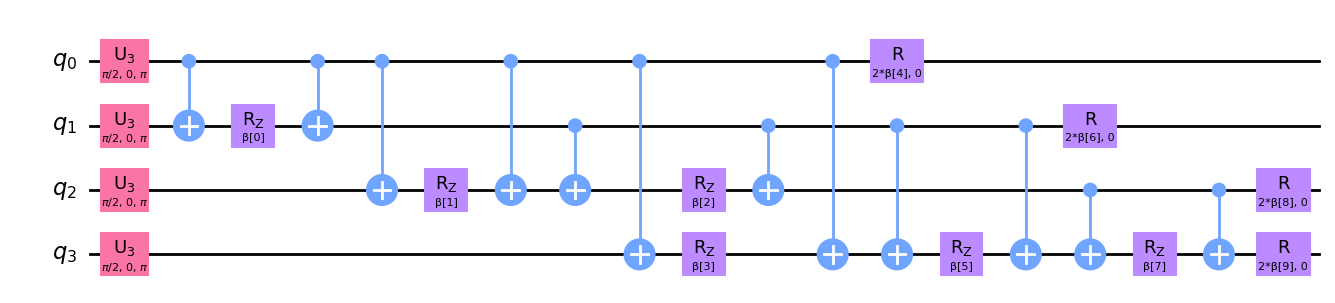

In [253]:
ansatz.draw('mpl')

In [240]:
ansatz.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0]), ParameterVectorElement(θ[6])])

In [117]:
'''
indices = []
for i in range(0,len(ansatz.data)):
    if ansatz.data[i].operation.name=='rx':
        indices.append(i)

for i in sorted(indices, reverse=True):
    del ansatz.data[i]
'''

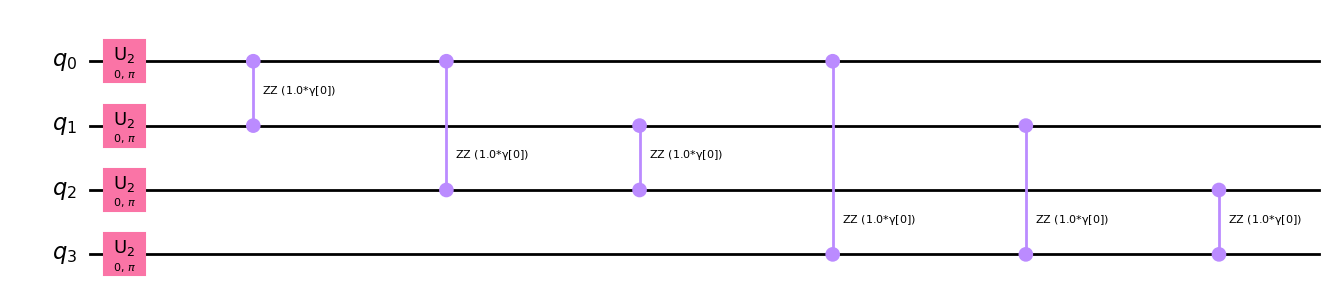

In [118]:
ansatz.draw('mpl')

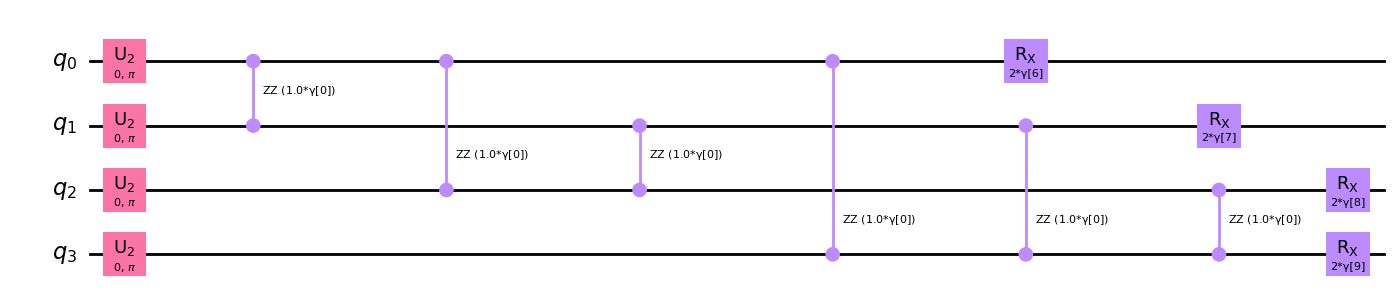

In [119]:
from qiskit.circuit import ParameterVector, QuantumCircuit
gamma = ParameterVector("γ",10) # for n = 4, len(theta) = 10

for i in range(0,n):
    ansatz.rx(2*gamma[6+i], i)

ansatz.draw('mpl')

In [254]:
new_ansatz = QuantumCircuit(n)

for d in ansatz.data[n:]:
    new_ansatz.data.append(d)

new_ansatz.parameters

ParameterView([ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9])])

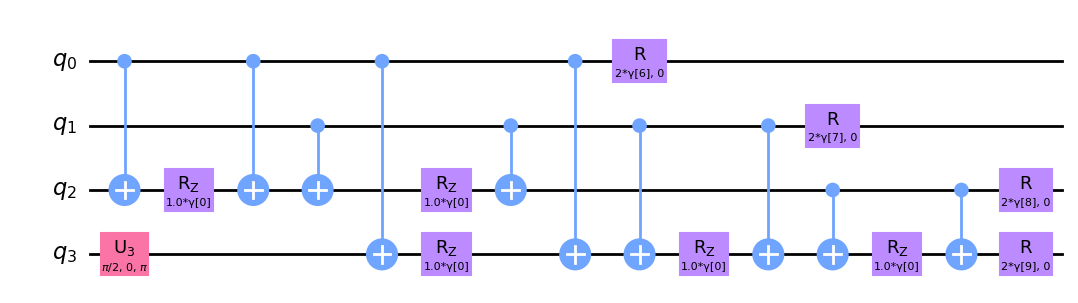

In [121]:
new_ansatz.decompose().draw('mpl')

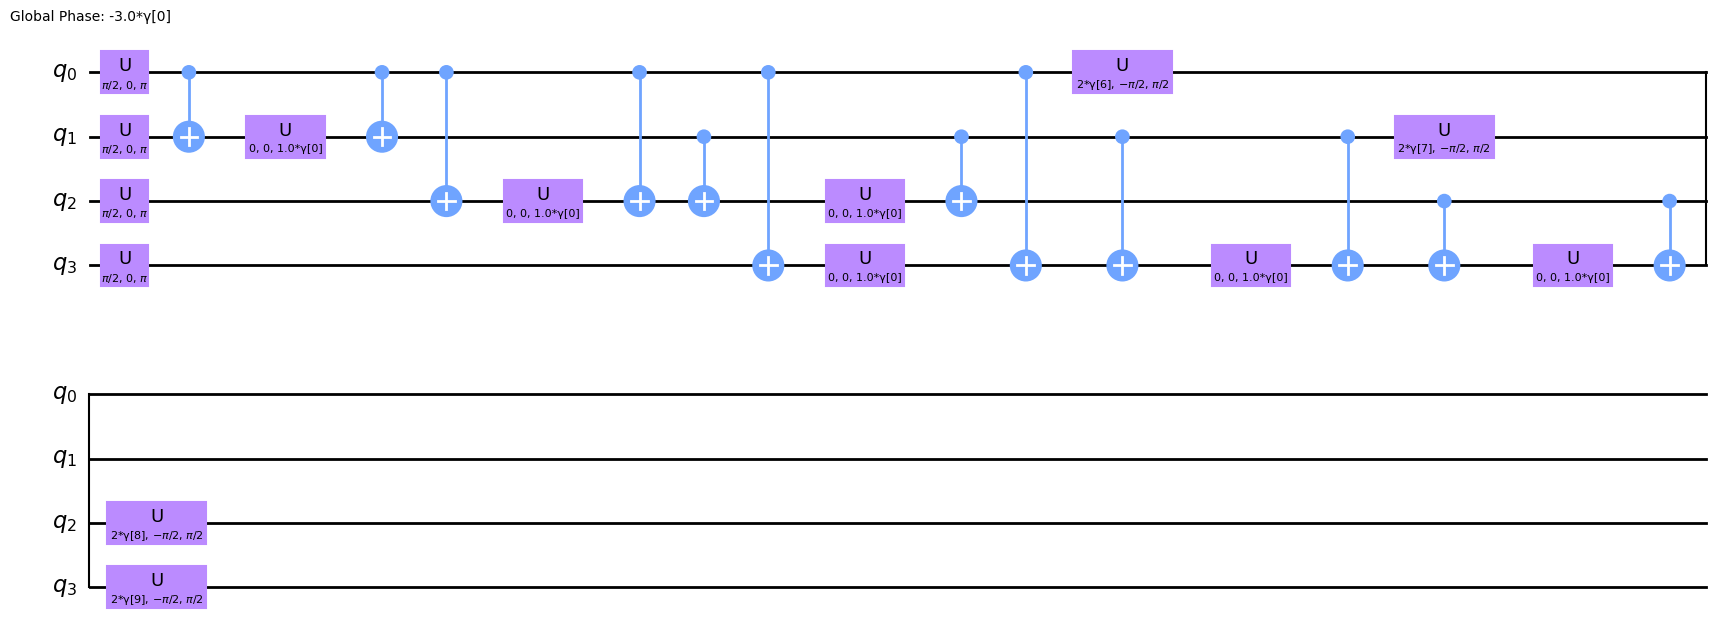

In [122]:
# Convert the NLocal ansatz type to QuantumCircuit and decompose 4 times to remove RZZ gates
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc &= ansatz.decompose(reps=4)
qc.draw('mpl')

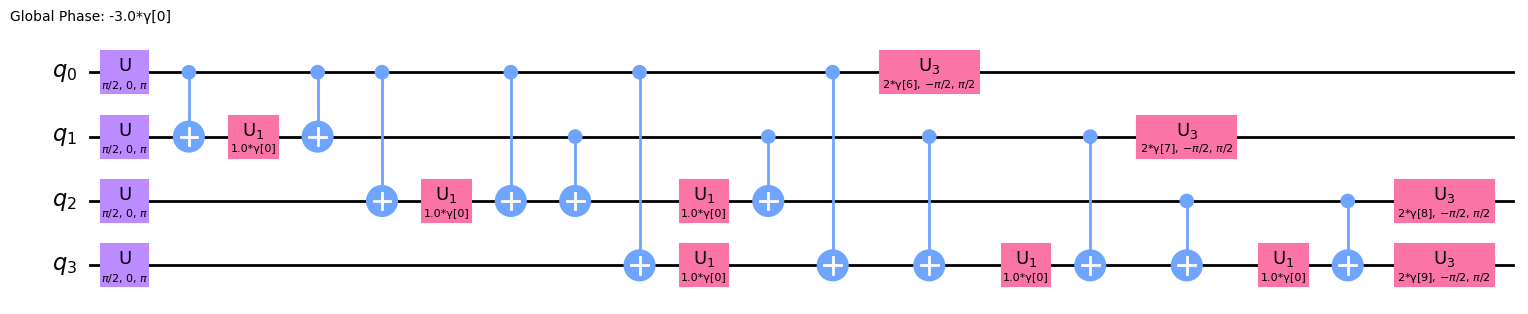

In [123]:
ansatz.decompose(reps=2).draw('mpl')

In [131]:
n = 4
m = n
adder = 4
n_param = 6

while n-4 > 0:
    #print(n_param+adder)
    n_param = n_param + adder
    adder = adder + 1
    n = n - 1

print(n_param)
n=m

6


10


/home/vhazoglou/miniconda3/envs/azure-knitting/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


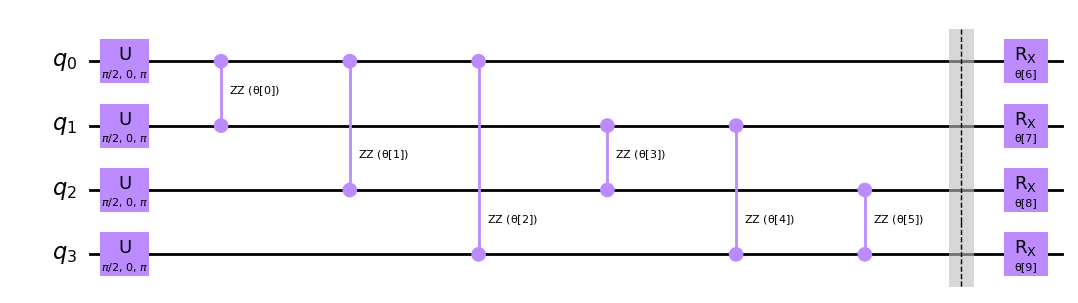

In [132]:
from qiskit.circuit import QuantumCircuit
import numpy as np
qaoa_qc = QuantumCircuit(n)
for i in range(0,n):
    qaoa_qc.u(np.pi/2, 0, np.pi, i)

from qiskit.circuit import ParameterVector
import math

theta = ParameterVector("θ", n_param + n) # for n = 4, len(theta) = 10

k = 0
for i in range(0,n):
    for j in range(i,n):
        if i != j:
            qaoa_qc.rzz(theta[k], i, j)
            k+=1

qaoa_qc.barrier()

for i in range(0, n):
    qaoa_qc.rx(theta[k+i], i)

print(len(theta))
#qaoa_qc = qaoa_qc.decompose()
qaoa_qc.draw('mpl')

In [133]:
new_ansatz.parameters

ParameterView([ParameterVectorElement(γ[0]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9])])

In [255]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import PauliList
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
    
def callback(eval_count, parameters, mean, std):
    print(f"Round num: {eval_count}, energy: {mean}, parameters: {parameters}")

estimator = Estimator()

# from our qubitOp
observables = qubitOp.paulis

# Cut QAOA result
cut_qaoa = CutQAOA(estimator, ansatz=new_ansatz, optimizer=optimizer, observables=observables, shots=2**12, max_subcircuit_width=n/2, max_cuts=20, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.2 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 287 rows, 125 columns and 962 nonzeros
Model fingerprint: 0x53620518
Variable types: 0 continuous, 125 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 287 rows and 125 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000e+00, best bound 7.000000000000e+00, ga

In [256]:
cut_qaoa_result = cut_qaoa.compute_minimum_eigenvalue(qubitOp)


KeyboardInterrupt: 